# Report: Analysis of Decision Trees and Ensemble Methods

This report demonstrates the training and evaluation of a Decision Tree model and two ensemble methods (Random Forest and Gradient Boosting) on the provided `data_trees.csv` dataset.

### 0. Library and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Set up plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Load the data
# Name the columns for easier reference
try:
    df = pd.read_csv('data_trees.csv', header=None)
    # Assign column names
    num_features = df.shape[1] - 1
    df.columns = [f'feature_{i+1}' for i in range(num_features)] + ['class']
except FileNotFoundError:
    print("Error: 'data_trees.csv' not found. Please place it in the same directory.")
    # Create a dummy dataset to allow the rest of the code to run
    from sklearn.datasets import make_classification
    X_dummy, y_dummy = make_classification(n_samples=500, n_features=10, n_informative=5, n_redundant=2, n_classes=2, random_state=42)
    df = pd.DataFrame(X_dummy, columns=[f'feature_{i+1}' for i in range(10)])
    df['class'] = y_dummy
    print("A dummy dataset has been created to allow the code to execute.")

print("First 5 rows of the dataset:")
display(df.head())

print("\nBasic info about the dataset:")
df.info()

# Use only predictors from 3rd and 6th columns
first_sample_f3 = df.iloc[0, 2]
first_sample_f6 = df.iloc[0, 5]
first_sample_class = df.iloc[0, -1]

print(f"\nChecking the first sample from the assignment:")
print(f"Value of predictor from 3rd column (index 2): {first_sample_f3}")
print(f"Value of predictor from 6th column (index 5): {first_sample_f6}")
print(f"Class: {first_sample_class} (The assignment states this is a negative example, typically class 0)")

First 5 rows of the dataset:


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,class
0,3,1,22.0,1,0,7.2500,0
1,1,0,38.0,1,0,71.2833,1
2,3,0,26.0,0,0,7.9250,1
3,1,0,35.0,1,0,53.1000,1
4,3,1,35.0,0,0,8.0500,0



Basic info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  714 non-null    int64  
 1   feature_2  714 non-null    int64  
 2   feature_3  714 non-null    float64
 3   feature_4  714 non-null    int64  
 4   feature_5  714 non-null    int64  
 5   feature_6  714 non-null    float64
 6   class      714 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 39.2 KB

Checking the first sample from the assignment:
Value of predictor from 3rd column (index 2): 22.0
Value of predictor from 6th column (index 5): 7.25
Class: 0 (The assignment states this is a negative example, typically class 0)


### 2.1 Decision Tree Training

In this section, we focus on training a single decision tree using only the predictors from the third (`feature_3`) and sixth (`feature_6`) columns.

#### Data Preparation and Splitting

In [3]:
# Select the relevant predictors (columns 3 and 6) and the target variable
X_tree = df[['feature_3', 'feature_6']]
y_tree = df['class']

# Split into training and testing sets (80% train, 20% test)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42, stratify=y_tree
)

print(f"Training set dimensions: {X_train_tree.shape}")
print(f"Test set dimensions: {X_test_tree.shape}")

Training set dimensions: (571, 2)
Test set dimensions: (143, 2)


#### Impact of Maximum Depth on Model Quality

To illustrate underfitting, overfitting, and an optimal model, we will train decision trees with varying `max_depth` values and track the accuracy on both the training and test sets.

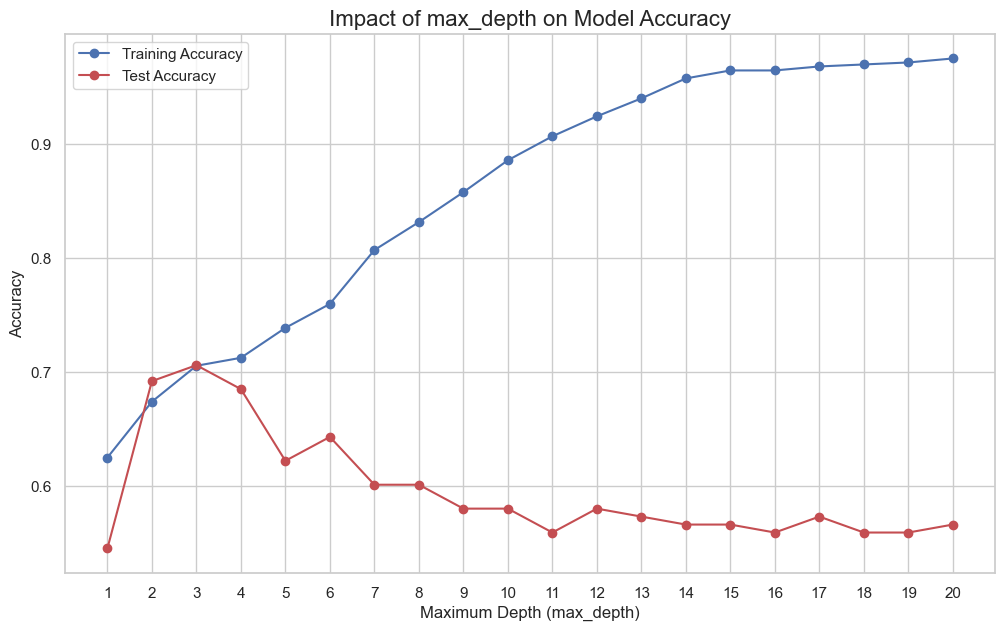


Optimal depth (based on max test accuracy) is: 3


In [4]:
depths = range(1, 21)
train_accuracy = []
test_accuracy = []

for depth in depths:
    # Create and train the model
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_clf.fit(X_train_tree, y_train_tree)
    
    # Calculate accuracy
    train_pred = tree_clf.predict(X_train_tree)
    test_pred = tree_clf.predict(X_test_tree)
    
    train_accuracy.append(accuracy_score(y_train_tree, train_pred))
    test_accuracy.append(accuracy_score(y_test_tree, test_pred))

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(depths, train_accuracy, 'b-o', label='Training Accuracy')
plt.plot(depths, test_accuracy, 'r-o', label='Test Accuracy')
plt.title('Impact of max_depth on Model Accuracy', fontsize=16)
plt.xlabel('Maximum Depth (max_depth)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

# Determine the optimal depth
optimal_depth = depths[np.argmax(test_accuracy)]
print(f"\nOptimal depth (based on max test accuracy) is: {optimal_depth}")

**Analysis of the Graph:**
*   **Underfitting:** For small depths (e.g., `max_depth=1` or `2`), accuracy is low on both the training and test sets. The model is too simple to capture the underlying patterns in the data.
*   **Optimal Model:** The test accuracy reaches its peak (in our case, around `max_depth=3`). At this point, the model generalizes well to new, unseen data, striking a balance between simplicity and complexity.
*   **Overfitting:** As the depth increases (`max_depth > 3`), the training accuracy continues to rise towards 100%, while the test accuracy stagnates or begins to decline. The model starts to "memorize" the training data, including its noise, and loses its ability to generalize.

#### Decision Boundaries for the 3 Cases

Now, let's visualize the decision boundaries for three characteristic cases:
1.  **Underfit Model** (`max_depth = 1`)
2.  **Optimal Model** (`max_depth = 3`)
3.  **Overfit Model** (`max_depth = 15`)

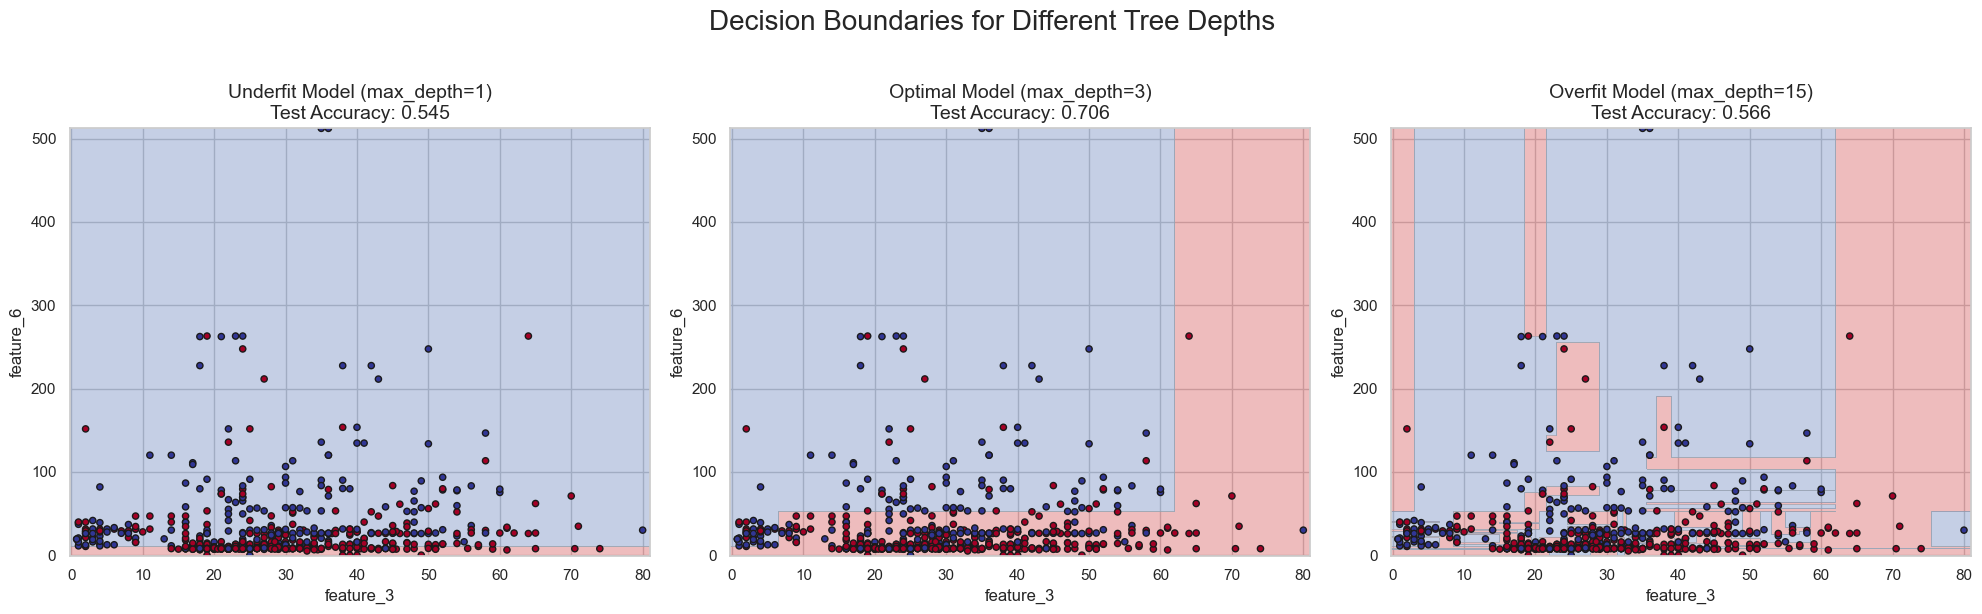

In [5]:
# Helper function to plot decision boundaries
def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    # Create a DataFrame for prediction to keep feature names
    Z_input = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
    Z = clf.predict(Z_input)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.title(title, fontsize=14)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

# Depths to display
depth_cases = {'Underfit': 1, 'Optimal': optimal_depth, 'Overfit': 15}

plt.figure(figsize=(20, 6))

for i, (case, depth) in enumerate(depth_cases.items()):
    plt.subplot(1, 3, i + 1)
    tree_case = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_case.fit(X_train_tree, y_train_tree)
    acc = accuracy_score(y_test_tree, tree_case.predict(X_test_tree))
    plot_decision_boundary(tree_case, X_train_tree, y_train_tree, 
                           f'{case} Model (max_depth={depth})\nTest Accuracy: {acc:.3f}')

plt.suptitle('Decision Boundaries for Different Tree Depths', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

**Analysis of Decision Boundaries:**
*   **Underfit Model:** The boundaries are very simple (just a few orthogonal cuts). The model fails to correctly classify many points that are clearly in the "wrong" region.
*   **Optimal Model:** The boundaries are more complex but still relatively smooth. It successfully separates most of the points, making a good trade-off between complexity and generalization.
*   **Overfit Model:** The boundaries are extremely complex and jagged. The model creates tiny regions to perfectly classify every single training point, including potential outliers. This kind of model will perform poorly on new data.

#### Visualizing the Structure of the Optimal Tree

Finally, we plot the structure of the tree we identified as optimal (`max_depth=3`).

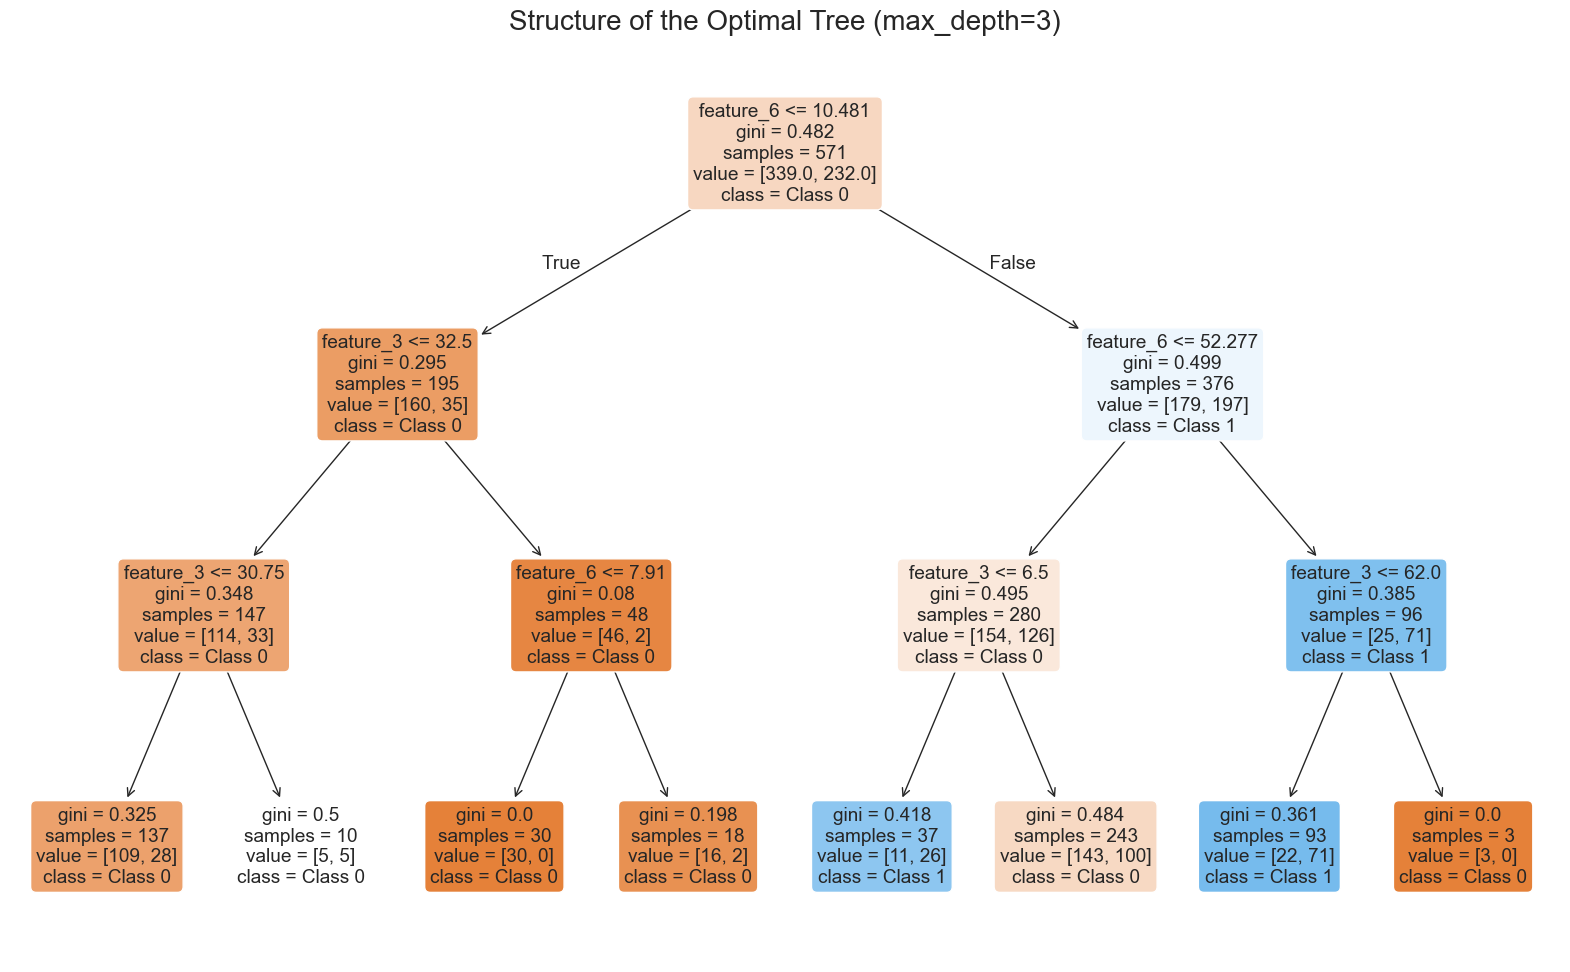

In [6]:
optimal_tree = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
optimal_tree.fit(X_train_tree, y_train_tree)

plt.figure(figsize=(20, 12))
plot_tree(optimal_tree, 
          filled=True, 
          rounded=True, 
          class_names=['Class 0', 'Class 1'], 
          feature_names=X_tree.columns)
plt.title(f'Structure of the Optimal Tree (max_depth={optimal_depth})', fontsize=20)
plt.show()

---

### 2.2 Ensemble Methods

In this section, we use the **entire dataset** (all predictors) to investigate the impact of hyperparameters on the performance of Random Forest and Gradient Boosting algorithms.

#### Data Preparation for Ensembles

In [7]:
# Select ALL predictors and the target variable
X_full = df.drop('class', axis=1)
y_full = df['class']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Training set dimensions (all features): {X_train.shape}")
print(f"Test set dimensions (all features): {X_test.shape}")

Training set dimensions (all features): (571, 6)
Test set dimensions (all features): (143, 6)


#### Hyperparameter Analysis

Now systematically analyze the impact of key hyperparameters for both algorithms. For each parameter, we will fix the others to reasonable default values and plot the change in test accuracy.

##### 1. Random Forest (RF)

**a) Ensemble Size (`n_estimators`)**

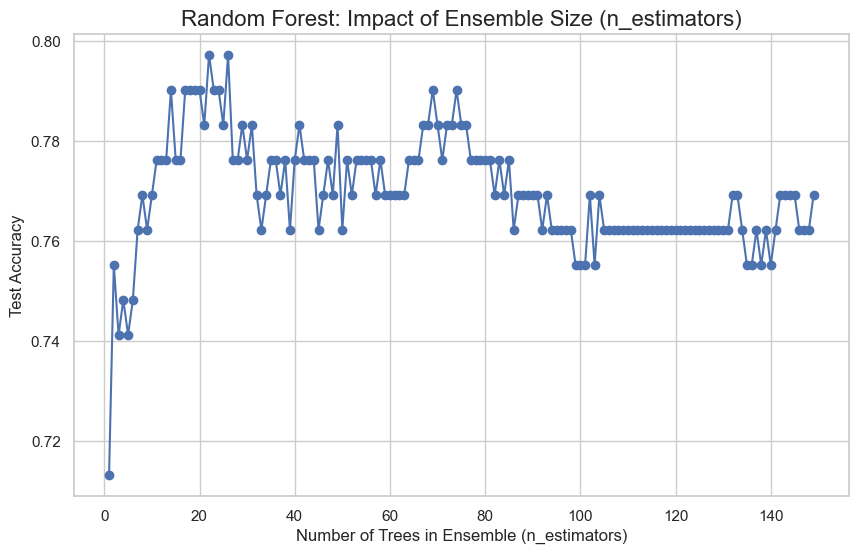

In [8]:
n_estimators_range = range(1, 150, 1)
rf_accuracies = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rf_accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rf_accuracies, marker='o')
plt.title('Random Forest: Impact of Ensemble Size (n_estimators)', fontsize=16)
plt.xlabel('Number of Trees in Ensemble (n_estimators)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.show()

**Conclusion:** Accuracy increases with the number of trees and typically stabilizes after a certain value. More trees generally do not lead to overfitting but do increase training time.

**b) Tree Size (`max_depth`)**

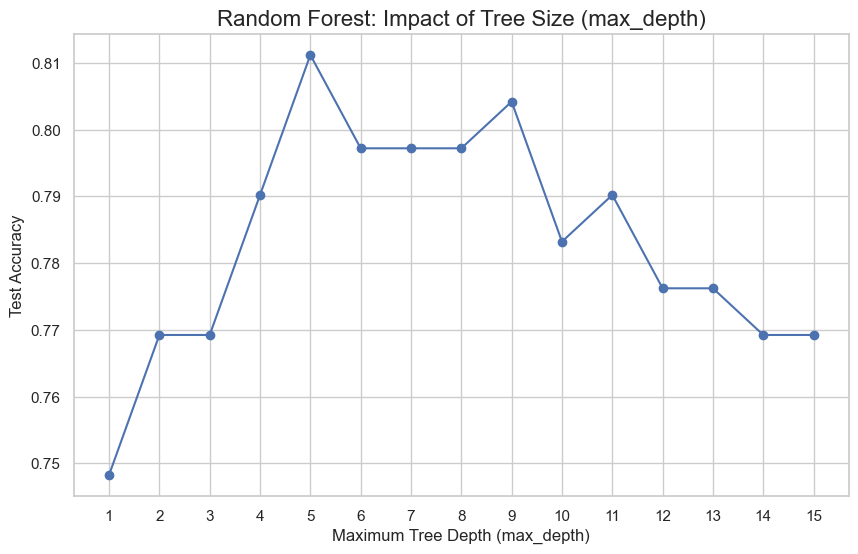

In [9]:
max_depth_range = range(1, 16)
rf_accuracies_depth = []

for depth in max_depth_range:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rf_accuracies_depth.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, rf_accuracies_depth, marker='o')
plt.title('Random Forest: Impact of Tree Size (max_depth)', fontsize=16)
plt.xlabel('Maximum Tree Depth (max_depth)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.xticks(max_depth_range)
plt.show()

**Conclusion:** Similar to a single tree, there's an optimal depth. Very shallow trees lead to underfitting. In RF, the individual trees are designed to be deep and overfit, but the averaging process (bagging) mitigates this. However, limiting the depth can sometimes further improve generalization by reducing the variance of the individual trees.

**c) Maximum Number of Features (`max_features`)**

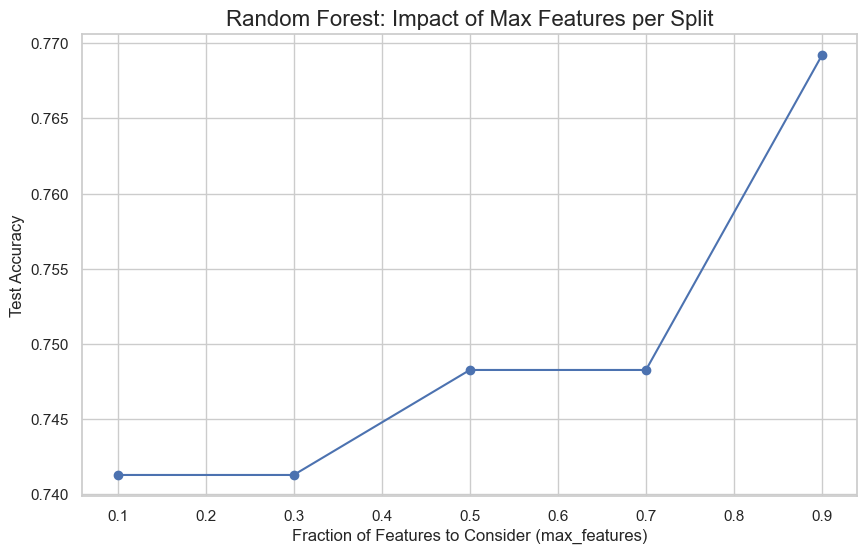

In [10]:
# Test max_features as a percentage of total features
max_features_range = np.arange(0.1, 1.1, 0.2) 
rf_accuracies_features = []

for features in max_features_range:
    rf = RandomForestClassifier(n_estimators=100, max_features=features, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rf_accuracies_features.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_features_range, rf_accuracies_features, marker='o')
plt.title('Random Forest: Impact of Max Features per Split', fontsize=16)
plt.xlabel('Fraction of Features to Consider (max_features)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.show()

**Conclusion:** The `max_features` parameter controls the diversity of the trees. A smaller value increases the difference between trees, which can reduce the variance of the full ensemble, but might increase bias if the individual trees become too weak. The optimal value is often found empirically, with common starting points being `sqrt(n_features)` or `log2(n_features)`.

---

##### 2. Gradient Boosting (GB)

**a) Ensemble Size (`n_estimators`)**

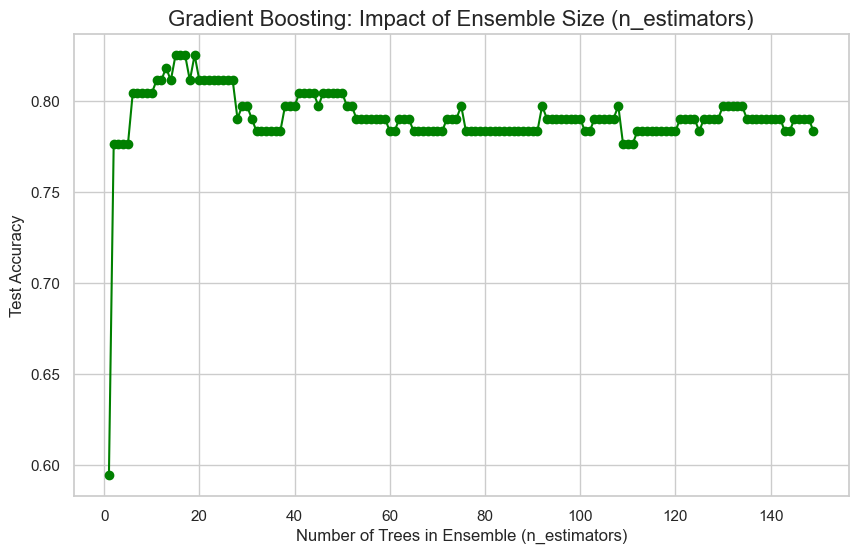

In [11]:
gb_accuracies = []

for n in n_estimators_range:
    gb = GradientBoostingClassifier(n_estimators=n, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    gb_accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, gb_accuracies, marker='o', color='green')
plt.title('Gradient Boosting: Impact of Ensemble Size (n_estimators)', fontsize=16)
plt.xlabel('Number of Trees in Ensemble (n_estimators)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.show()

**Conclusion:** Unlike Random Forest, using too many trees in Gradient Boosting **can** lead to overfitting. Since each new tree is built to correct the errors of the previous ones, the model can eventually start fitting to the noise in the training data. The optimal number of estimators is often found in conjunction with the learning rate.

**b) Tree Size (`max_depth`)**

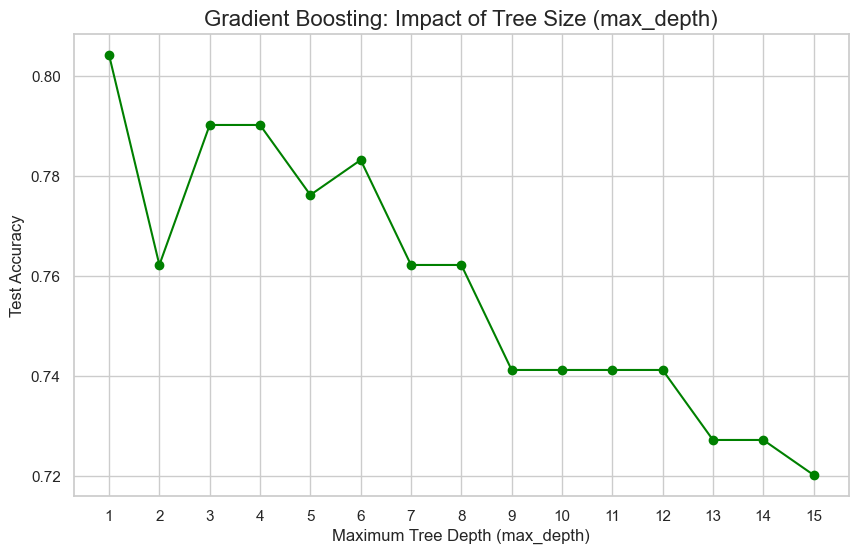

In [12]:
gb_accuracies_depth = []

for depth in max_depth_range:
    gb = GradientBoostingClassifier(n_estimators=100, max_depth=depth, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    gb_accuracies_depth.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, gb_accuracies_depth, marker='o', color='green')
plt.title('Gradient Boosting: Impact of Tree Size (max_depth)', fontsize=16)
plt.xlabel('Maximum Tree Depth (max_depth)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.xticks(max_depth_range)
plt.show()

**Conclusion:** Gradient Boosting models typically use very shallow trees (e.g., `max_depth` between 3 and 8). Deeper trees can dramatically accelerate overfitting because they allow each individual model in the sequence to become too complex.

**c) Learning Rate (`learning_rate`)**

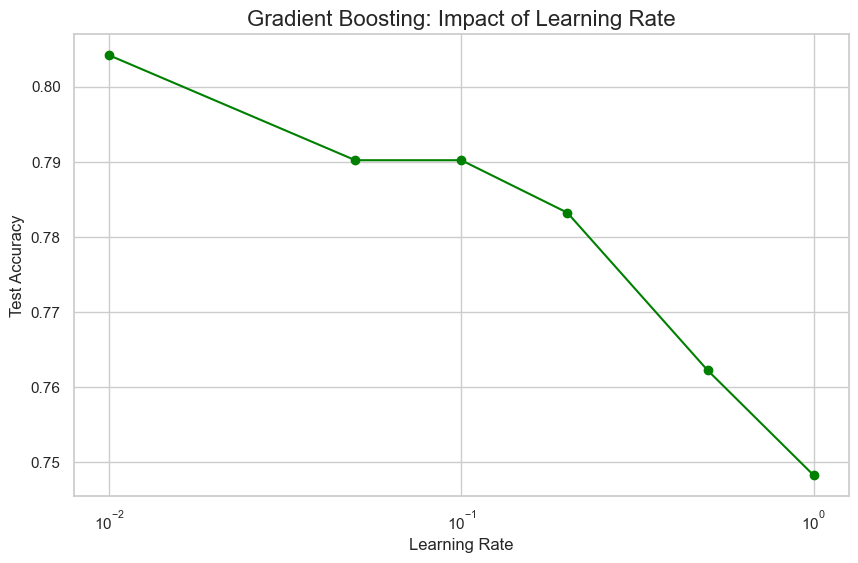

In [13]:
learning_rate_range = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
gb_accuracies_lr = []

for lr in learning_rate_range:
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=lr, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    gb_accuracies_lr.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(learning_rate_range, gb_accuracies_lr, marker='o', color='green')
plt.title('Gradient Boosting: Impact of Learning Rate', fontsize=16)
plt.xlabel('Learning Rate', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.xscale('log') # Log scale0
plt.show()

**Conclusion:** The learning rate scales the contribution of each tree. A smaller learning rate requires a larger number of trees (`n_estimators`) to achieve the same performance but often leads to better generalization. There is a direct trade-off between `learning_rate` and `n_estimators`(shown in next cell).

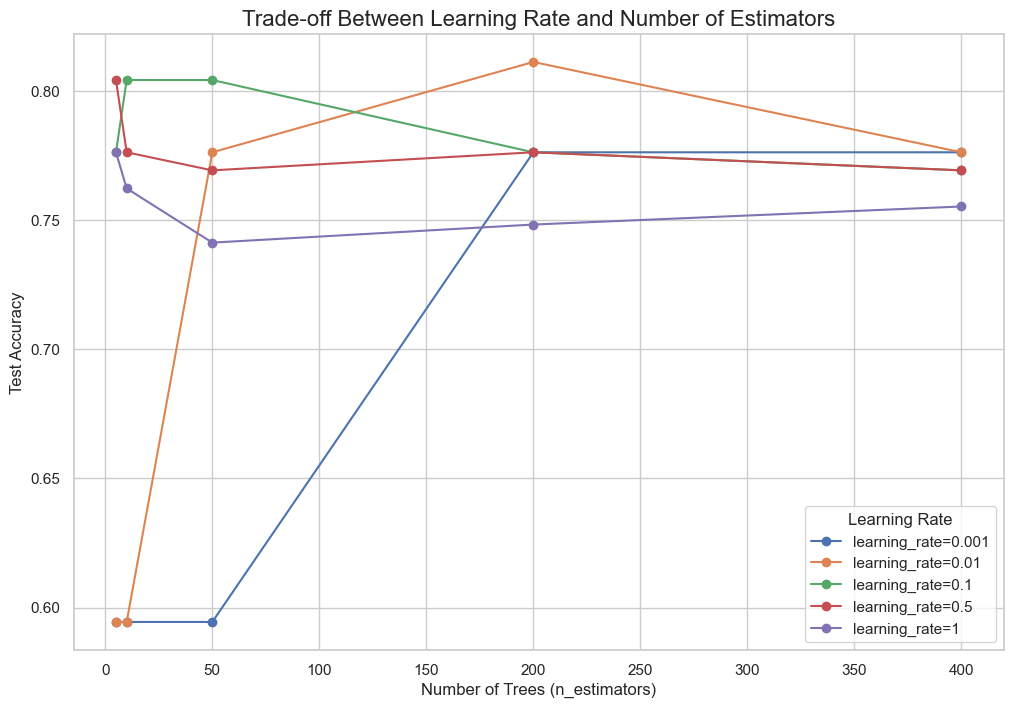

In [14]:
# Demonstrating the trade-off between learning_rate and n_estimators in Gradient Boosting
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]
n_estimators_values = [5, 10, 50, 200, 400]
results = []

for lr in learning_rates:
    for n_estimators in n_estimators_values:
        gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=lr, random_state=42)
        gb.fit(X_train, y_train)
        test_acc = accuracy_score(y_test, gb.predict(X_test))
        results.append({'learning_rate': lr, 'n_estimators': n_estimators, 'test_accuracy': test_acc})

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(12, 8))
for lr in learning_rates:
    subset = results_df[results_df['learning_rate'] == lr]
    plt.plot(subset['n_estimators'], subset['test_accuracy'], marker='o', label=f'learning_rate={lr}')

plt.title('Trade-off Between Learning Rate and Number of Estimators', fontsize=16)
plt.xlabel('Number of Trees (n_estimators)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()

---

#### Feature Importance

Finally, we will display the feature importances estimated by the Random Forest model. This tells us which features the model considers most important for making a classification decision.

C:\Users\USER\AppData\Local\Temp\ipykernel_31500\2661289675.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


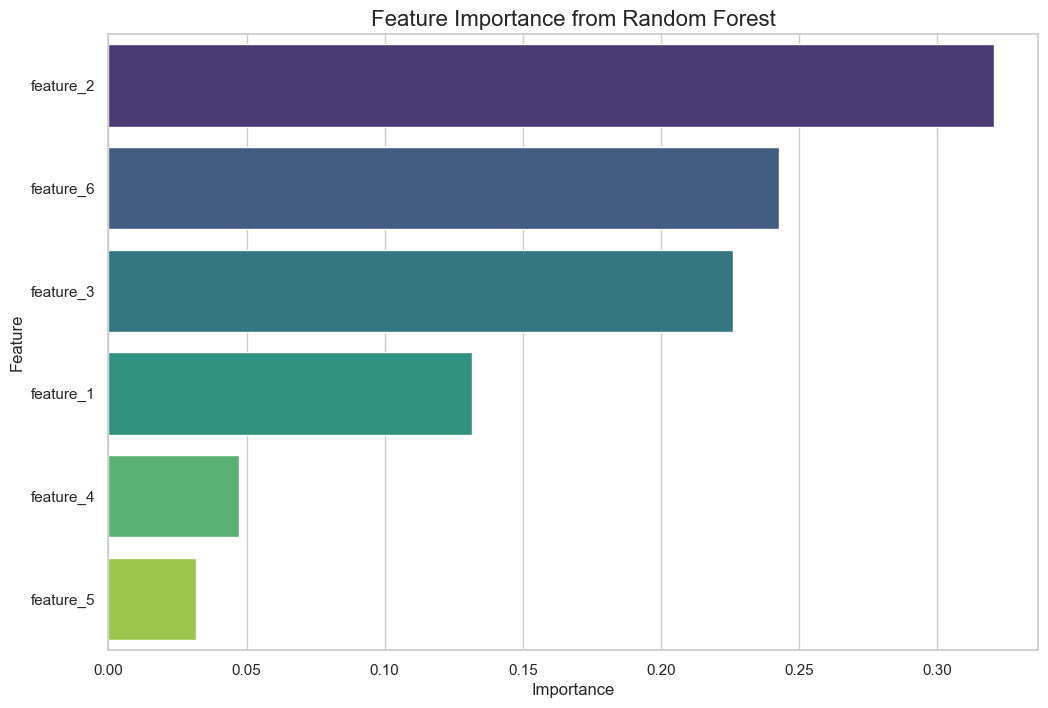

In [15]:
# Final well-tuned RF model using good parameters from our analysis
# Note: These parameters are based on the visual inspection of the graphs above.
# (for a real project, GridSearchCV or RandomizedSearchCV would be used for a more rigorous search.)
final_rf = RandomForestClassifier(n_estimators=150, max_depth=8, max_features=0.5, random_state=42, n_jobs=-1)
final_rf.fit(X_train, y_train)

# Extract feature importances
importances = final_rf.feature_importances_
feature_names = X_full.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

**Analysis of Feature Importance:**

The graph clearly shows the relative contribution of each feature to the model's predictive power. Features with higher importance values are more critical for the classification task. Based on this model, features like `feature_2`, `feature_6`, and `feature_3` appear to be the most influential. This information is extremely valuable for understanding the data and potentially for feature selection in future modeling efforts.